2025-07-24 16:49:00.835227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 16:49:02.116696: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 16:49:02.323723: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Setting up for Zonal-Mean Out-of-Sample Test (PCA version) ---
Loading normalization data...
✅ Normalization data loaded successfully.

Loading and preprocessing 4xCO2 test data...
✅ Test data preprocessed.

--- Running Ensemble Predictions for 4xCO2 ---
    Loading model: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/model_fold1_ens1.h5
    Loading PCA transformer: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom/pca_y_fold1.pkl


2025-07-24 16:49:09.466737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 16:49:10.492681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0
2025-07-24 16:49:12.198874: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


5/5 [==============================] - 4s 12ms/step
(150, 177)
    Loading model: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/model_fold2_ens1.h5
    Loading PCA transformer: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom/pca_y_fold2.pkl
5/5 [==============================] - 0s 8ms/step
(150, 176)
    Loading model: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/model_fold3_ens1.h5
    Loading PCA transformer: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom/pca_y_fold3.pkl
5/5 [==============================] - 0s 8ms/step
(150, 176)
    Loading model: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/model_fold4_ens1.h5
    Loading PCA transformer: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.

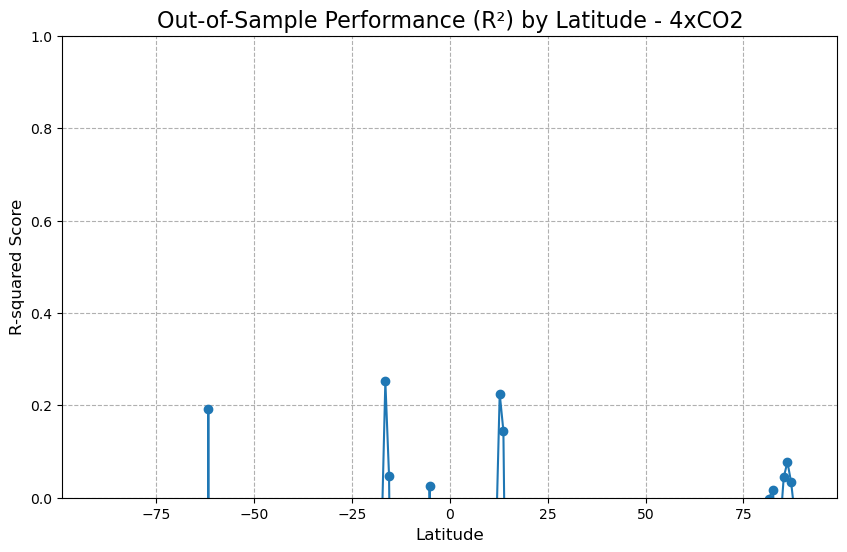


    Plotting Truth vs. Prediction as contour maps...


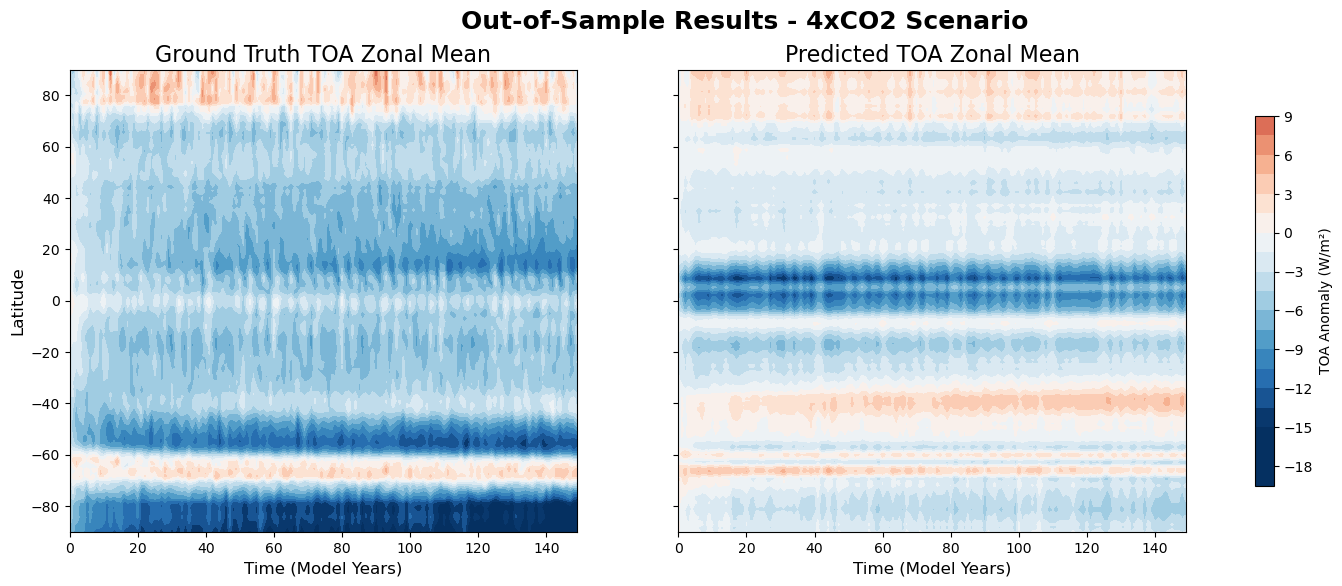

In [1]:
# ===================================================================
# FINAL OUT-OF-SAMPLE TEST SCRIPT FOR 2D ZONAL-MEAN MODELS (with PCA)
# ===================================================================
# This script is specifically designed to test models that were
# trained by applying PCA to the target variable (y).
# It correctly loads the saved PCA transformer for each fold.

import os
import gc
import joblib # <-- Required to load the PCA model
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from keras.models import load_model
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# --- 1. Configuration: Set Correct Paths for the PCA Model Run ---
print("--- Setting up for Zonal-Mean Out-of-Sample Test (PCA version) ---")

# **FIX**: Define separate paths for models vs. pca/log files
# path_model_dir = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D_PCA'
# path_results_dir = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_2D_PCA/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom'

#C1:
path_model_dir = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA"
path_results_dir = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_PCA/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom"


# Define variable names for your test files
In_name = "TS"
Out_name = "TOA_anom"

# Define paths to your out-of-sample 4xCO2 test files
# file_4xCO2_input = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
# file_4xCO2_output = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.zmean.ANN.nc"
file_4xCO2_input = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
file_4xCO2_output = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.zmean.ANN.new.nc"


# --- 2. Load Normalization Data from the Training Run ---
print("Loading normalization data...")
# **FIX**: Normalization file is in the main model directory
normalization_path = os.path.join(path_model_dir, 'Normalization_zonal.mat')
normalization = sio.loadmat(normalization_path)
X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']
print("✅ Normalization data loaded successfully.")

# --- 3. Load and Preprocess 4xCO2 Test Data ---
print("\nLoading and preprocessing 4xCO2 test data...")
ds_4xCO2_X = xr.open_dataset(file_4xCO2_input)
ds_4xCO2_y = xr.open_dataset(file_4xCO2_output)

TS_4xCO2_raw = ds_4xCO2_X[In_name]
TOA_4xCO2_truth = ds_4xCO2_y[Out_name].values
lat = ds_4xCO2_X['lat'].values
time_4xCO2 = ds_4xCO2_X['year'].values if 'year' in ds_4xCO2_X else ds_4xCO2_X['time'].values

TS_4xCO2_norm = (TS_4xCO2_raw.values[..., np.newaxis] - X_mean) / X_std
print("✅ Test data preprocessed.")

# --- 4. Prediction Loop with PCA Inverse Transform ---
print("\n--- Running Ensemble Predictions for 4xCO2 ---")
n_folds = 5
predictions_from_folds = []

for fold_no in range(1, n_folds + 1):
    K.clear_session(); gc.collect()
    
    # **FIX**: Construct the full path to the .h5 file and the .pkl file
    model_path = os.path.join(path_model_dir, f'model_fold{fold_no}_ens1.h5')
    pca_path = os.path.join(path_results_dir, f'pca_y_fold{fold_no}.pkl')
    
    print(f"    Loading model: {model_path}")
    print(f"    Loading PCA transformer: {pca_path}")
    
    # Load the trained model from its .h5 file path and the PCA transformer
    model = load_model(model_path, compile=False)
    pca_y = joblib.load(pca_path)
    
    # 1. Predict the PCA components
    pred_4xco2_pca = model.predict(TS_4xCO2_norm)
    print(pred_4xco2_pca.shape)
    
    # 2. Inverse transform from PCA space to normalized data space
    pred_4xco2_norm = pca_y.inverse_transform(pred_4xco2_pca)
    
    # 3. Un-normalize the data
    pred_4xco2_unnorm = pred_4xco2_norm * y_std + y_mean
    
    predictions_from_folds.append(pred_4xco2_unnorm)

# Average predictions across the folds
Model_pred_4xco2 = np.mean(np.stack(predictions_from_folds), axis=0)
print("\n✅ Prediction complete.")


# =================================================================
# Out-of-Sample Analysis and Visualization (No changes needed here)
# =================================================================
print("\n--- Starting Out-of-Sample Analysis ---")

# --- Task 1: Calculate Overall Pattern Correlation ---
print("\n    Calculating Overall Pattern Correlation...")
truth_flat = TOA_4xCO2_truth.flatten()
pred_flat = Model_pred_4xco2.flatten()
pattern_r, _ = pearsonr(truth_flat, pred_flat)
print(f"✅ Overall Pattern Correlation (r) = {pattern_r:.4f}")

# --- Task 2: Plot R-squared as a Function of Latitude ---
print("\n    Calculating and plotting R-squared per latitude...")
r2_by_latitude = [r2_score(TOA_4xCO2_truth[:, i], Model_pred_4xco2[:, i]) for i in range(len(lat))]

plt.figure(figsize=(10, 6))
plt.plot(lat, r2_by_latitude, marker='o', linestyle='-')
plt.title('Out-of-Sample Performance (R²) by Latitude - 4xCO2', fontsize=16)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.grid(True, linestyle='--'); plt.ylim(0, 1)
plt.show()

# --- Task 3: Plot Truth vs. Prediction as a 2D Contour Map ---
print("\n    Plotting Truth vs. Prediction as contour maps...")

time_axis_for_plot = np.arange(TOA_4xCO2_truth.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
vmax = np.percentile(np.abs(TOA_4xCO2_truth), 98)
vmin = -vmax

axes[0].set_title('Ground Truth TOA Zonal Mean', fontsize=16)
cf1 = axes[0].contourf(time_axis_for_plot, lat, TOA_4xCO2_truth.T, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set_xlabel('Time (Model Years)', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)

axes[1].set_title('Predicted TOA Zonal Mean', fontsize=16)
cf2 = axes[1].contourf(time_axis_for_plot, lat, Model_pred_4xco2.T, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('Time (Model Years)', fontsize=12)

fig.colorbar(cf1, ax=axes.ravel().tolist(), shrink=0.8, label='TOA Anomaly (W/m²)')
fig.suptitle("Out-of-Sample Results - 4xCO2 Scenario", fontsize=18, fontweight='bold')
plt.show()